# Assignment 1 — Least Squares Method

Sergio Alejandro Vargas \
Universidad Nacional de Colombia \
Introduction to Optimization 2022-I

> The dependencies for this notebook are listed in the [./Project.toml](./Project.toml). IJulia will automatically run the notebook in this [project's environment](https://julialang.github.io/IJulia.jl/dev/manual/usage/#Julia-projects), so we don't need to worry about dependency versioning.

In [1]:
using CSV,
    DataFrames,
    Plots,
    Statistics

## 1. Conditions for the Least Squares Method

If we have an overdetermined system $Ax = b$ we can approximate a solution using the Linear Least Squares Method (**LLS**) with an euclidean norm, which as we've seen can be formulated as
$$
\hat{x} = {\arg\min}_{x} \|Ax - b\|_2^2
$$

However, for this approximation to work we need to assume that:

1. The columns of the design matrix $A$ are linearly independent: If they were not, that would mean that one or more parameters are a linear combination of other parameters, i.e. they're redundant parameters. Of course, when the columns of $A$ are linearly dependent, that means the pseudo-inverse $A^\dagger$ is not defined and there's no way to estimate $\hat{x}$ LLS.

2. The residuals have a constant variance: If the variance varied with our observations, i.e. if the size of the residual depends on the values of $b$, our fitted line would be biased in favor of the observations with a small residual. For example, if the variance was directly proportional to our observations, we could have good stimations for small inputs, but very bad stimations for large inputs.

## 2. Non-linear Least Squares model for the Bitcoin data set

First, we need a data set to run our analysis. I've used the [Yahoo finance API](https://yahoofinanceapi.com/) to get the time series for Bitcoin (and the commodities used in the next problem statement).
The CSV files contain the closing price during the past year.

> The script used to get the data is in [src/fetch_data.jl](./src/fetch_data.jl).
> And the data itself is stored in CSV files in the [./data](./data) directory.

In [2]:
"Helper function to get the closing prices vector directly"
read_data(stock::String) = CSV.read("./data/$stock.csv", DataFrame);

In [3]:
const BTC = read_data("bitcoin").close;

Let's plot the growth during the past year, and let's see the minimum and maximum values to give us a point of comparison.

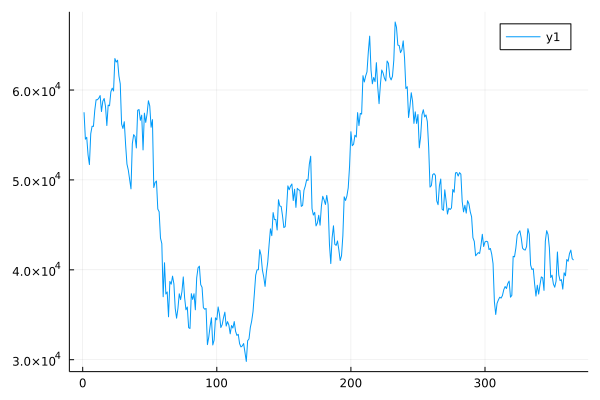

In [4]:
plot(BTC)

In [5]:
extrema(BTC)

(29807.348, 67566.83)

Welp. we certainly won't be able to fit a line through that graph. So 2 things seem clear. We should:

1. Use a non-linear function: let's try to use a polynomial model for our prediction of the Bitcoin price. We don't know a priori which degree of polynomial would get us the best results, so we'll try multiple ones, and choose the "best" one at the end.

2. Use a smaller time interval: The price of seems to have some periods of stability with some large jumps in-between, so let's the values after the large drop before the 300 mark.


 Our model now looks like:

$$
y = p_1x^{n} + p_2x^{n-1} + \dots + p_{n-1}x + p_n
$$

Where we want to find the vector of parameters $p = [p_1, p_2, \dots, p_n]$.


In [6]:
# a polynomial model of n parameters 
function model(x::Real, p::Vector{<:Real})
    n = length(p)
    sum(p[i] * x^(n-i) for i in 1:n)
end;

In [7]:
# Create a design matrix of `r` rows and `d` columns
# (where `d` is the degree of the polynomial we want to adjust)
make_design_matrix(r, d::Integer) = hcat([(1:r).^i for i in (d):-1:0]...);

In [8]:
# Split data into training data and test data (last week's prices)
BTCtrain, BTCtest = BTC[280:(end-6)], BTC[(end-5):end];

In [9]:
const N = length(BTCtrain); # number of "observations"

In [10]:
# Start with a polynomial model of degree 7
function f₇(x)
    M = make_design_matrix(N, 7)
    p = M \ BTCtrain
    model(x, p)
end

f₇ (generic function with 1 method)

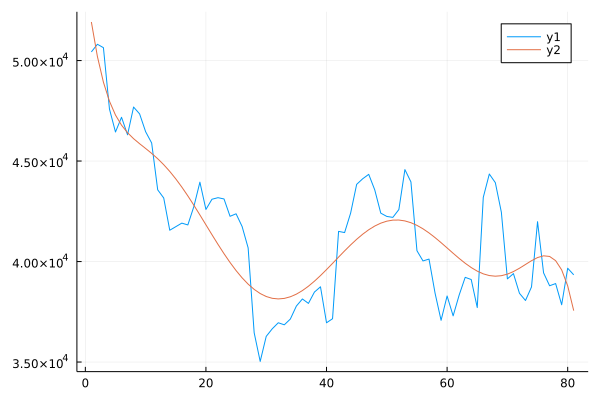

In [11]:
plot(BTCtrain); plot!(f₇, 1:N)

Ok. Could be worse…

Now lets see how polynomials of other degrees do against our first guess.

In [12]:
function poly_params(data, d::Integer)
    M = make_design_matrix(length(data), d)
    M\data
end

poly_params (generic function with 1 method)

In [13]:
fs = [x -> model(x, poly_params(BTCtrain, n)) for n in 1:10]

10-element Vector{var"#6#8"{Int64}}:
 #6 (generic function with 1 method)
 #6 (generic function with 1 method)
 #6 (generic function with 1 method)
 #6 (generic function with 1 method)
 #6 (generic function with 1 method)
 #6 (generic function with 1 method)
 #6 (generic function with 1 method)
 #6 (generic function with 1 method)
 #6 (generic function with 1 method)
 #6 (generic function with 1 method)

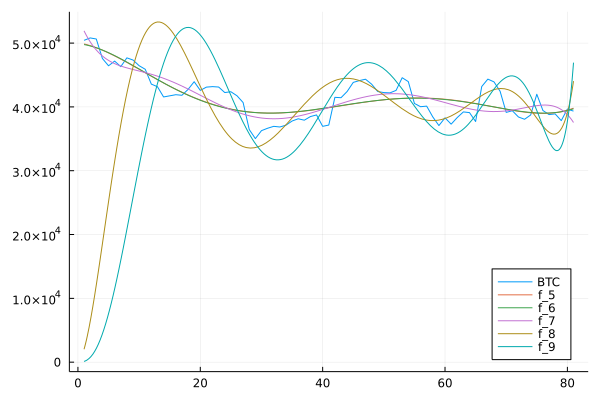

In [14]:
begin
    plot(BTCtrain; label="BTC", legend_position=:bottomright)
    plot!(fs[5]; label="f_5")
    plot!(fs[6]; label="f_6")
    plot!(fs[7]; label="f_7")
    plot!(fs[8]; label="f_8")
    plot!(fs[9]; label="f_9")
end

Other polynomials don't seem like an improvement… but if we take a close look we'll see that $f₅$ and $f₆$ are extremely close to one another.

Let's check those in more detail

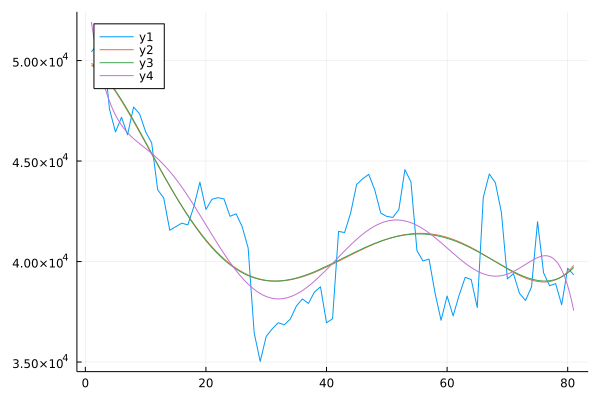

In [15]:
begin
    plot(BTCtrain; legend_position=:topleft)
    plot!(fs[5])
    plot!(fs[6])
    plot!(fs[7])
end

Let's see how well these predict the real price of Bitcoin during the last week

In [16]:
const interval = length(BTCtrain):(length(BTCtrain)+5)

81:86

In [17]:
test_residuals(f) = abs.(BTCtest - f.(interval));

In [18]:
mean(test_residuals(fs[6]))

1121.2808783811136

In [19]:
mean(test_residuals(fs[6]))

1121.2808783811136

In [20]:
mean(test_residuals(fs[7]))

11031.360685935122

We can see that for the three functions, the residual will be around 1000 USD during the week. This doesn't seem too bad for an asset being traded at around 40000 USD, but it probably isn't enough to give us a competitive strategy.

## 3. Is the Bitcoin price related to the price of hard commodities?

we'll analyse the recent historical value of various hard commodities (gold, silver and crude oil), to see if their price relates to the price of Bitcoin.

Once again, we load our data using the helper function `read_data`

In [21]:
begin
    bitcoin = read_data("bitcoin")
    au = read_data("gold")
    ag = read_data("silver")
    crude = read_data("crude")
end;

First, notice that the price of oil and silver are negligible when compared with the current price of Bitcoin. But even ignoring Bitcoin, these commodities seem have a much more stable pricing.

> To run our analysis we need to filter some entries of the Bitcoin table because Bitcoin is traded every day, but the commodities only during trading days.

In [22]:
begin
    btc = filter(:date => day -> day in au.date, bitcoin)
    gold = au.close
    silver = ag.close
    oil = crude.close
end;

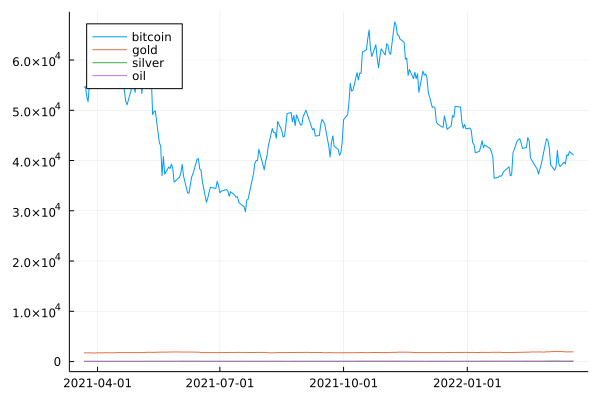

In [23]:
begin
    plot(btc.date, btc.close; label="bitcoin", legend_position=:topleft)
    plot!(au.date, au.close; label="gold")
    plot!(ag.date, ag.close; label="silver")
    plot!(crude.date, crude.close; label="oil")
end

## REFERECES

- S. Boyd, L. Vandenberghe. _Introduction to Applied Linear Algebra: Vectors, Matrices, and Least Squares_. Cambridge University Press, 2018